# Imports

Import python libraries as well as the self written FERMI library.

In [ ]:
!pip install --user pyFAI

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import h5py
from os.path import join, split
from glob import glob
from time import strftime
from imageio import imread

import pyFAI
pyFAI.disable_opencl=True # get rid of annoying warning ;)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector
from pyFAI.calibrant import Cell, Calibrant

#from scipy.ndimage.filters import median_filter 

import sys, os
#sys.path.append('./FERMI_2021-11/kg/')

import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import process_FERMI_2022 as pf

from tqdm.auto import tqdm

from importlib import reload
from copy import deepcopy

In [3]:
#interactive plotting
%matplotlib widget

In [4]:
def plot_image(im, fname):
    fig, ax = plt.subplots(tight_layout=True)
    m = ax.imshow(im)
    plt.colorbar(m)
    ax.grid(False)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_ai(df, time, samplefolder, scanfolder, fname, vmin = 0):
    fig, ax = plt.subplots(tight_layout=True)
    az2d.plot.imshow(ax = ax, cmap = 'viridis', vmin = vmin)
    ax.set_title(f'{samplefolder} / {scanfolder}: delay %.2fps'%time)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_curve(xdata, ydata, fname, xlabel = '', ylabel = ''):
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(xdata, ydata, 'o-')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.savefig(fname, dpi=100)
    plt.close(fig)
    
def load_images_averaged(flist):
    '''Load CCD image for list of files and return average.'''
    list_images = [pf.loadh5(f)[0] for f in flist]
    return np.mean(list_images, axis=0).astype(float)

def load_image_corrected(fname, fnameBG, fnameOF, fnameOL):
    '''Load a single CCD image and apply background corrections and normalize.
    
    Parameters
    ----------
    fname : str
        filename of image file
    fnameBG : str
        filename of dark background file
    fnameOF : str
        filename of "only FEL" background file
    fnameOL : str
        filename of "only Laser" background file
    
    Returns
    -------
    image : np.ndarray
        The corrected and normalized image
    '''
    flist = [fname, fnameBG, fnameOF, fnameOL]
    images = {}
    norm = {}
    for name, filename in zip(['im', 'bg', 'of', 'ol'], flist):
        im, meta = pf.loadh5(filename, extra_keys={'diode_sum': 'PAM/FQPDSum'})
        im = im.astype(float)
        images[name] = im
        norm[name] = meta['diode_sum'].sum()
    image = ((images['im'] - images['ol']) / norm['im']
             - (images['of'] - images['bg']) / norm['of'])
    return image

# load non-image data

Specify the folder of the run you want to analyze. No need to have the exact folder of the HDF files. The function *get_exp_dataframe* works recursively and gets all HDF files into the pandas DataFrame. It will also already take specific values that you can specify in *extra_keays* and save them into the same DataFrame.

In [5]:
basefolder = '/home/gerlinger/Documents/Beamtimes/2021-11_FERMI/Data/'
samplefolder = 'CoPt_63'
scanfolder = 'G3_DelayScan_018'
t0 = 9.925

datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnetWF': 'DPI/CoilWaveform',
    'bunches': 'bunches',
    'time': '',
    'global_delay': 'Laser/DelayTotem',
}

exp = pf.get_exp_dataframe(datafolder, keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp[k + '_sum'] = exp[k].apply(np.sum)

exp['diode_sum_mean'] = exp.diode_sum.apply(np.mean)
exp['diode_sum_std'] = exp.diode_sum.apply(np.std)
exp['IR_mean'] = exp.IR.apply(np.mean)
exp['IR_std'] = exp.IR.apply(np.std)
exp['magnet'] = exp.magnetWF.apply(np.min)
exp['bunchid'] = exp.bunches.apply(lambda l: l[-1])

exp['delay_ps'] = 6.67 * (exp['delay'] - t0)  + (600 - exp['global_delay'])

exp = exp.sort_values('delay_ps')

In [6]:
fsave = f'/home/gerlinger/Documents/Beamtimes/2021-11_FERMI/Processed/{samplefolder}/{scanfolder}/'

if not os.path.exists(fsave):
    os.mkdir(fsave)

## load dark

### Background

In [7]:
exp_bg = pf.get_exp_dataframe(datafolder + '_BG', keys=extra_keys)
exp_bg = exp_bg.sort_values('time')

darkfolder = datafolder + '_BG'
flist = glob(darkfolder + '/**/*h5', recursive=True)
dark_bg = load_images_averaged(flist)

### Laser only

In [8]:
exp_ol = pf.get_exp_dataframe(datafolder + '_OL', keys=extra_keys)
exp_ol = exp_ol.sort_values('time')

darkfolder = datafolder + '_OL'
flist = glob(darkfolder + '/**/*h5', recursive=True)
dark_ol = load_images_averaged(flist)

### FEL only

In [9]:
exp_of = pf.get_exp_dataframe(datafolder + '_OF', keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp_of[k + '_sum'] = exp_of[k].apply(np.sum)
exp_of = exp_of.sort_values('time')

darkfolder = datafolder + '_OF'
flist = glob(darkfolder + '/**/*h5', recursive=True)
dark_of = load_images_averaged(flist) / exp_of.diode_sum_sum.mean()

# Plot single image

Load an image and it's meta data. This will be used to setup the azimuthal integrator.

In [10]:
i = 20
im1, _ = pf.loadh5(exp.iloc[i]['filename'])
im1 = im1 - dark_ol
im1 = im1 / exp.diode_sum_sum.iloc[i]
im1 = im1 - (dark_of - dark_bg) / exp_of.diode_sum_sum.mean()
imdelay1 = exp.delay_ps.iloc[i]

i = -1
im2, _ = pf.loadh5(exp.iloc[i]['filename'])
im2 = im2 - dark_ol
im2 = im2 / exp.diode_sum_sum.iloc[i]
im2 = im2 - (dark_of - dark_bg) / exp_of.diode_sum_sum.mean()
imdelay2 = exp.delay_ps.iloc[i]

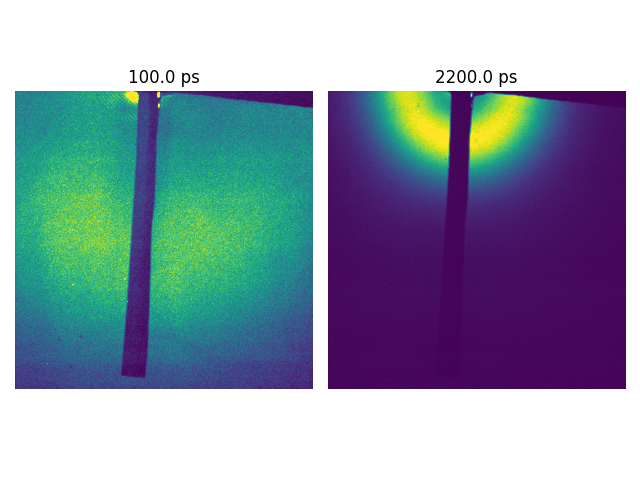

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
mi, ma = np.percentile(im1, (1, 99))
ax[0].imshow(im1, vmin=mi, vmax=ma)
ax[0].set_axis_off()
ax[0].set_title(f'{imdelay1:.1f} ps')
mi, ma = np.percentile(im2, (1, 99))
ax[1].imshow(im2, vmin = mi, vmax = ma)
ax[1].set_axis_off()
ax[1].set_title(f'{imdelay2:.1f} ps')
fig.tight_layout()

In [12]:
# fig, ax = plt.subplots(frameon=False, tight_layout = True, figsize = (5,5))
# mi, ma = np.percentile(im2, (1, 99))
# ax.imshow(im2[:624, 135:724+35], vmin = mi, vmax = ma, cmap = 'cividis')
# ax.set_axis_off()

In [13]:
# plt.savefig('/home/gerlinger/Documents/Projects/FERMI/Paper 2021/Figures/SAXSpattern.png')

# Mask

The masks are created by hand by Kathinka using GIMP and loaded into the masks image folder. Please check if the binarization worked correctly (Kathinka will probably forget if she used white for 1 and black for 0 or the other way around...

In [14]:
mask_manual = imread('/home/gerlinger/Documents/Beamtimes/2021-11_FERMI/Masks/ccd_mask2_greedy.png')[..., 0]
# mask_manual = imread('../images/masks/CoPtnoAl_B4Scan007_mask.png')[..., 0]
mask_manual = mask_manual != 255

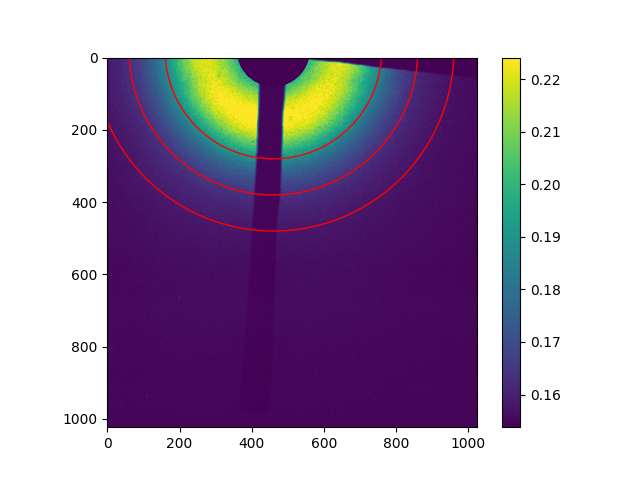

In [15]:
center = [-20, 460]  # off-set, binned
# center = [0, 950]  # off-set, full chip
# center = [1000, 950]

rmin = 100

beamstop = None

mask = pf.make_mask(im2, center, rmin, beamstop=beamstop)
mask *= mask_manual

mask_nan = np.where(mask == 0, np.nan, 1)

In [16]:
# plt.imsave('/home/gerlinger/Dokumente/Beamtimes/2020-06_FERMI/Masks/CoPt_50nmAl_C6_im.png', im3 * mask_nan, vmin = mi, vmax = ma)

# Set up the azimuthal integration
This has to be done only once (unless the image center shifts, or the image shape changes).
Reusing the AzimuthalIntegrator instance is very fast.

You need to specifiy the center (determine it via the plotted image above). The rest is filled in automatically from the image shape and image meta data. 

In [17]:
detector = Detector(2 * 13.5e-6, 2 * 13.5e-6)  # binned!
ai = AzimuthalIntegrator(dist=(exp['ccdz'][0] + 33) / 1000,
                         rot2=-np.deg2rad(exp['ccd_rot'][0]),
                         poni2=455 * 13.5e-6 * 2,
                         poni1=1080 * 13.5e-6 * 2,
                         detector=detector,
                         wavelength=exp['wavelength'][0] * 1e-9)

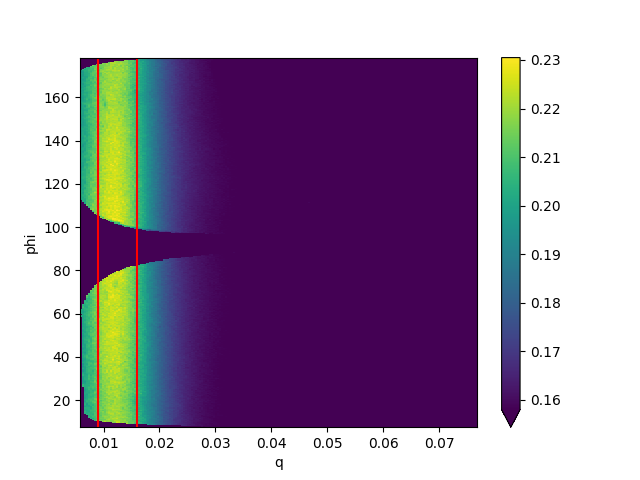

In [18]:
I_t, q_t, phi_t = ai.integrate2d(im2, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle=False)
az2d = xr.DataArray(I_t, dims = ('phi', 'q'), coords = {'q':q_t, 'phi': phi_t})
fig, ax = plt.subplots()
az2d.plot.imshow(ax = ax, vmin = .158)
ax.axvline(.009, ymin = 0, ymax = 180, c = 'red')
ax.axvline(.016, ymin = 0, ymax = 180, c = 'red')

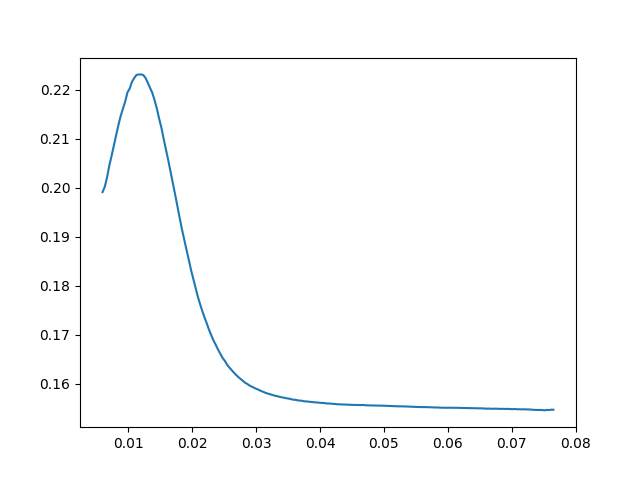

In [19]:
q, I = ai.integrate1d(im2, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)

fig, ax = plt.subplots()
ax.plot(q, I)

# Process delay scan
set up empty DataArray using xarray 

Now, all images are loaded and processed. The azimutal integration is saved in the scan xarray. If you see strange things happening in your results plot, set *debug_plots* to **True**. This will save all images in the scan into our tmp folder and you can take a look at them.

In [20]:
scan = xr.DataArray(
    np.zeros([len(exp), len(q_t)]),
    dims=['delay_ps', 'q'],
    coords={'q': q, 'delay_ps': exp.delay_ps}
)

scan_plot = xr.DataArray(
    np.zeros([len(exp), len(q_t)]),
    dims=['delay_ps', 'q'],
    coords={'q': q, 'delay_ps': exp.delay_ps}
)

mean_im = []

debug_plots = False
folder_save = fsave + f'debug/'
im_plot = True
folder_save_im = fsave + f'images/'

norm_key = 'diode_sum_sum'

expmean = np.mean(exp[norm_key])
expstd = np.std(exp[norm_key])

plt.ioff()
ctt = 0
for index, r in tqdm(exp.iterrows(), total=len(exp)):
    if (scanfolder == 'G8_DelayScan_024') & (r['delay_ps'] > 15) & (r['delay_ps'] < 25):
        print(f'Image at 20ps of Scan {scanfolder} is empty, probably no FEL, discard it!')
        scan_plot.loc[{'delay_ps': r['delay_ps']}] = np.nan
        scan.loc[{'delay_ps': r['delay_ps']}] = np.nan
        continue
    #exp_bg['sort_delay'] = np.abs(exp_bg['delay_ps'] - r['delay_ps'])
    #idx = np.where(exp_bg['sort_delay'] == np.min(exp_bg['sort_delay']))[0][0]
    idx = np.argmin(abs(r.time - exp_bg.time))
    ct = 0
            
    # Load image files
    file_BG = exp_bg.iloc[idx]['filename']
    dark_BG = pf.loadh5(file_BG)[0].astype(int)
    
    file_OL = exp_ol.iloc[idx]['filename']
    dark_OL = pf.loadh5(file_OL)[0].astype(int)
    
    file_OF = exp_of.iloc[idx]['filename']
    dark_OF = pf.load_image_diodenorm(file_OF, dark_BG, normkey='PAM/FQPDSum')
    
    im = pf.load_image_diodenorm(r['filename'], dark_OL, normkey='PAM/FQPDSum')
    im = im - dark_OF
    
    q, I = ai.integrate1d(im, 200, unit='q_nm^-1', mask=1 - mask,
                          correctSolidAngle=False, dummy=np.nan)
    if debug_plots:
        if not os.path.exists(folder_save):
            os.mkdir(folder_save)
        I_t, q_t, phi_t = ai.integrate2d(im, 200, unit='q_nm^-1', mask=1 - mask,
                                         correctSolidAngle=False, dummy=np.nan)
        az2d = xr.DataArray(I_t, dims = ('phi', 'q'), coords = {'q':q_t, 'phi': phi_t})
        plot_ai(az2d, r['delay_ps'], samplefolder, scanfolder, folder_save + '%.2f.png'%(r['delay_ps']))
        
    if im_plot:
        if not os.path.exists(folder_save_im):
            os.mkdir(folder_save_im)
        mi, ma = np.percentile(im*mask, (.1, 99.9))
        fig, ax = plt.subplots(1,2, tight_layout = True, figsize = (12,6))
        ax[0].imshow(im * mask, vmin = mi, vmax = ma)
        ax[0].set_axis_off()
        ax[1].plot(q, I)
        ax[1].set_xlabel(r'$q$')
        ax[1].set_ylabel('scattered intensity')
        fig.suptitle('%i ps'%round(r['delay_ps']))
        plt.savefig(folder_save_im + f'saxs1d_{ctt}.png')
        ctt += 1
        plt.close(fig)
        
    scan.loc[{'delay_ps': r['delay_ps']}] = I
    if np.abs(r[norm_key] - expmean) < 2 * expstd:
        scan_plot.loc[{'delay_ps': r['delay_ps']}] = I
    else:
        scan_plot.loc[{'delay_ps': r['delay_ps']}] = np.nan
        print('%.1f ps: Skipped because the diode signal is too small.'%(r['delay_ps']))

plt.ion()

#scan_plot = scan_plot.groupby('delay_ps').mean()
scan_plot = scan_plot.dropna('delay_ps')
scan = scan.dropna('delay_ps')

  0%|          | 0/42 [00:00<?, ?it/s]

80.0 ps: Skipped because the diode signal is too small.
1800.0 ps: Skipped because the diode signal is too small.


## plot

In [21]:
qmin, qmax = 0.0, np.max(scan.q)

demag = scan.where((scan['q'] > qmin) & (scan['q'] < qmax)).sum('q')
demag_plot = scan_plot.where((scan_plot['q'] > qmin) & (scan_plot['q'] < qmax)).sum('q')

qmean = scan.where((scan['q'] > qmin) & (scan['q'] < qmax)).mean('q')

Text(0.5, 0.98, 'CoPt_63 G3_DelayScan_018: IR 17.4 µJ, magnet: 0.50 A')

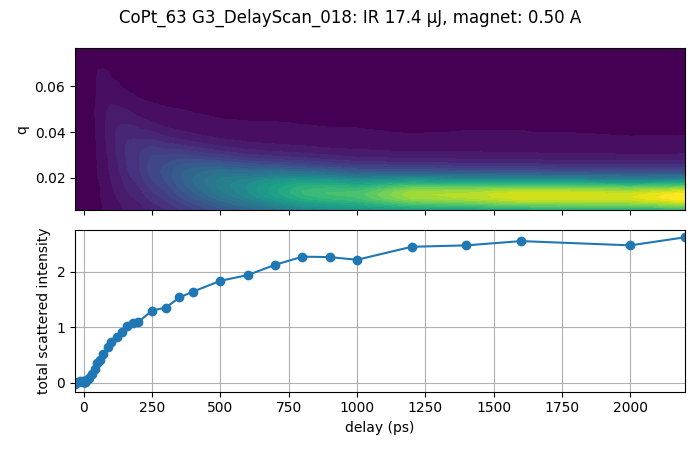

In [22]:
fig, ax = plt.subplots(nrows=2, ncols = 1, figsize=(7, 4.5), sharex=True, tight_layout=True)
vmin, vmax = float(scan_plot.min()), float(scan_plot.max())
scan_plot.plot.contourf(
    x='delay_ps', y='q', ax=ax[0], cmap='viridis', add_colorbar=False,
    vmin=vmin, vmax=vmax, levels=30
)

ax[1].plot(demag_plot.delay_ps, demag_plot, 'o-')
ax[1].grid()
ax[0].set_xlabel('')
ax[1].set_ylabel('total scattered intensity')
ax[1].set_xlabel('delay (ps)')

ir = exp['IR_mean'].mean()
mag = exp.magnet.mean()
fig.suptitle(f'{samplefolder} {scanfolder}: IR {ir:.1f} µJ, magnet: {mag:.2f} A')

# sel = demag_plot.delay_ps > 750
# reg = linregress(demag_plot.delay_ps[sel], demag_plot[sel])

# reg_delay = np.array([750, 12000])
# ax[1].plot(reg_delay, reg.intercept + reg.slope * reg_delay, c='r', lw=.5)

In [203]:
exp.to_hdf(fsave + f'{scanfolder}.h5', key = 'Exp_Data')
scan.to_netcdf(fsave + f'{scanfolder}_Scan.h5')
scan_plot.to_netcdf(fsave + f'{scanfolder}_Scan-plot.h5')
demag.to_netcdf(fsave + f'{scanfolder}_Demag.h5')
demag_plot.to_netcdf(fsave + f'{scanfolder}_Demag-plot.h5')

/home/gerlinger/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:2431: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['filename', 'xgm_UH', 'xgm_SH', 'filter_EH_in', 'filter_UH_in',
       'diode_I0', 'diode_sum', 'IR', 'valve_pos2', 'valve_dpi3', 'comment',
       'magnetWF', 'bunches'],
      dtype='object')]

  pytables.to_hdf(


## Final states

In [25]:
#final state
exp_fs = pf.get_exp_dataframe(datafolder + '_FinalState', keys=extra_keys)
exp_fs['time_delta'] = exp_fs.time - exp.time[0]
exp_fs['total_intensity'] = np.nan

scan_fs = xr.DataArray(
    np.zeros([len(exp_fs), len(q)]),
    dims=['image', 'q'],
    coords={'q': q, 'image': exp_fs.index.values}
)

I_fs_list=[]
for i in exp_fs.index:
    idx = np.argmin(abs(exp_fs.loc[i, 'time'] - exp_bg.time))
    fname = exp_fs.loc[i, 'filename']
    
    file_BG = exp_bg.iloc[idx]['filename']
    dark_BG = pf.loadh5(file_BG)[0].astype(int)
    
    file_OF = exp_of.iloc[idx]['filename']
    dark_OF = pf.load_image_diodenorm(file_OF, dark_BG, normkey='PAM/FQPDSum')
    
    im_fs = pf.load_image_diodenorm(fname, dark_BG, normkey='PAM/FQPDSum')
    im_fs = im_fs - dark_OF
    
    q_fs, I_fs = ai.integrate1d(im_fs, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)
    scan_fs.loc[i] = I_fs
    
    exp_fs.loc[i, 'total_intensity'] = np.sum(I_fs)
#print(exp_fs.total_intensity)

Text(0, 0.5, 'normalized intensity')

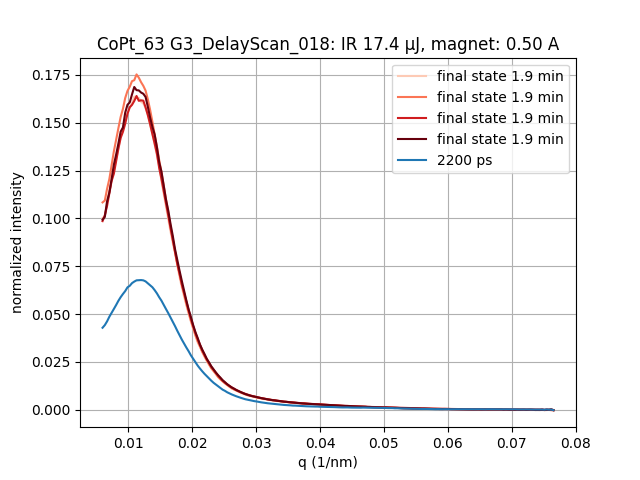

In [26]:
fig, ax = plt.subplots()
colors = plt.get_cmap('Reds')(np.linspace(.2, 1, len(scan_fs)))
for i in scan_fs.image:
    i = int(i)
    dt = exp_fs.time_delta.iloc[i]
    ax.plot(scan_fs.q, scan_fs.loc[i], c=colors[i], label=f'final state {dt / 60:.1f} min')

scan_max_delay = scan.isel({'delay_ps': -1})
ax.plot(scan.q, scan_max_delay, label=f'{float(scan_max_delay.delay_ps):.0f} ps')
ax.legend()
ax.grid(True)
ax.set_title(f'{samplefolder} {scanfolder}: IR {ir:.1f} µJ, magnet: {mag:.2f} A')
ax.set_xlabel('q (1/nm)')
ax.set_ylabel('normalized intensity')

In [206]:
exp_fs.to_hdf(fsave + f'{scanfolder}_final.h5', key = 'Exp_Data')
scan_fs.to_netcdf(fsave + f'{scanfolder}_Scan_final.h5')

/home/gerlinger/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:2431: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['filename', 'xgm_UH', 'xgm_SH', 'filter_EH_in', 'filter_UH_in',
       'diode_I0', 'diode_sum', 'IR', 'valve_pos2', 'valve_dpi3', 'comment',
       'magnetWF', 'bunches'],
      dtype='object')]

  pytables.to_hdf(


In [207]:
plt.close('all')

# Misc

## Single images

In [47]:
i = 20
idx = np.argmin(abs(exp.iloc[i].time - exp_bg.time))
        
# Load image files
file_BG = exp_bg.iloc[idx]['filename']
dark_BG = pf.loadh5(file_BG)[0].astype(int)

file_OL = exp_ol.iloc[idx]['filename']
dark_OL = pf.loadh5(file_OL)[0].astype(int)

file_OF = exp_of.iloc[idx]['filename']
dark_OF = pf.load_image_diodenorm(file_OF, dark_BG, normkey='PAM/FQPDSum')

im = pf.load_image_diodenorm(exp.iloc[i].filename, dark_OL, normkey='PAM/FQPDSum')
im = im - dark_OF

imdelay1 = exp.delay_ps.iloc[i]

In [48]:
np.save(fsave + f'{scanfolder}_im{int(imdelay1)}.npy', im * mask, allow_pickle = False)

In [49]:
mi, ma = np.percentile(im*mask, (0,99))
fig, ax = plt.subplots()
m = ax.imshow(im * mask, vmin = 0, vmax = ma)
plt.colorbar(m)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Azimutal Integration for specific images

In [ ]:
imagelist = {
    '5258.h5': 2.5,
    '1426.h5': 5,
    #'0249.h5': 7.5,
    '5428.h5': 10,
    #'3233.h5': 12.5,
    '3233.h5': 15,
    '6571.h5': 17.5,
    '8033.h5': 20,
}

In [ ]:
filtered = pf.filtering(f'{basefolder}{samplefolder}/', list(k for k in imagelist.keys()))
filtered = [f for f in filtered if 'C4' in f]

In [ ]:
sortf = np.array([filtered[0]] * len(filtered))
imarray = np.array(list(k for k in imagelist.keys()))
for file in filtered:
    idx = np.where(imarray == file[-7:])[0][0]
    sortf[idx] = deepcopy(file)

In [ ]:
az_int = []
images = []
for f in sortf:
    im, meta = pf.loadh5(f, extra_keys={'diode_sum': 'PAM/FQPDSum',})
    im = (im - dark.astype(float))/ np.sum(meta['diode_sum'])
    im -= (np.mean(im[-50:, 500:]) + before)
    images.append(im)
    q, I = ai.integrate1d(im * mask, 200, unit='q_nm^-1')
    az_int.append(I / norm)
integrated = xr.DataArray(az_int, dims=['labels', 'q'], coords = {'q': q})
images = np.array(images)

In [ ]:
integrated[-2].to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_final-state.h5')
I_fel = integrated[-2]

In [ ]:
label = np.round(np.array([ 2.08208978,  4.16417957,  6.24626935,  8.32835914, 10.41044892, 12.4925387 , 14.57462849, 16.65671827]), decimals = 1)
blues = ['#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
# plot, instead of the file endings you can also define a label list and iterate through that list
fig, ax = plt.subplots()
ct = 0
for data in integrated:
    ax.plot(integrated.q, data, blues[ct], label = f'{label[ct]} mJ/cm$^2$')
    ct += 1
plt.legend()
ax.set_xlabel('q (nm$^{-1}$)')
ax.set_ylabel('intensity (a.u.)')
ax.grid()
ax.set_title(f'{samplefolder} / {scanfolder}: Magnet %.1f A'%mag_max)
fig.tight_layout()

## Get magnet information

This is only done when doing a delay scan to check what the maximal magnet amperage was and at which amperage the FEL hit the sample.

Since this process should be identical for each delay, we only take the magnet info from the image that was plotted above.

Please check that the lower plateau was correctly found! If the orange curve is only 1 on these lower plateaus everything is fine. If not, please change the chunksize (the numbers of points over which the slope is calculated) or the maximum slope. The default values, also here as default in the template, are *chunksize = 500, max_slope = 4e-7*.

In [419]:
def get_magnet(fname, offset = .2, plot = True, chunksize = 500, max_slope = 4e-7):
    scan = split(split(split(fname)[0])[0])[-1]
    sample = split(split(split(split(fname)[0])[0])[0])[-1]
    with h5py.File(fname, 'r') as f:
        magnet = f['Lecroy/Wave3'][()]
    mag_mean = np.mean(magnet, axis = 0) + offset
    mag_lower = np.mean(mag_mean[np.where(pf.zero_slope(mag_mean, 500) == 1)])
    mag_upper = np.max(mag_mean)
    if plot:
        sname = split(fname)[-1]
        fig, ax = plt.subplots()
        ax.plot(mag_mean, label = 'mean')
        ax.plot(pf.zero_slope(mag_mean, chunksize, max_slope), label = 'magnet change')
        ax.grid()
        ax.set_xlabel('time (a.u.)')
        ax.set_ylabel('magnet current (A)')
        ax.legend()
        ax.set_title(f'{sample}/{scan}' + ': max = %.1f, min = %.1f'%(mag_upper, mag_lower)) #include max and min of magnet current in title
        #fig.savefig(f'../images/Magnet/{sname}.png')
    return (magnet, mag_lower, mag_upper)

In [414]:
dd = np.float(scan.sel(delay_ps=40, method='nearest').delay)

In [420]:
magnet, mag_min, mag_max = get_magnet(exp.loc[exp.delay == dd]['filename'].values[0], offset = .3,
                                 chunksize = 500, max_slope = 4e-7, plot = True) #exp.iloc[0]['filename']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'zero_slope' is not defined